# This is an example for appliying the model to the data acquired from a real robot experiment.
## 1. Introduction
### We manipulated the Franka robot by hands to do several putting-in demonstrations with toys. To be specific, we first moved the end effector to a staring point, and held it for seconds, and leaded it to the goal point for the putting-in task, and held the end effector there also for seconds, and moved it to a new starting point and do the same thing again. 
### We totally did the demonstration for 6 times, and at the meantime using the code to record the changes of the end effector position(3 dimension), and unit quaternion(4dimension) of orientation during the whole process.
## 2. Pre-processing

In [1]:
import os
import numpy as np
import scipy.io as spio
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
# load the data from the recording file
realtrial = np.loadtxt(os.getcwd() + "/../data/Robot_data/realTrial.txt")
# extract our concerning data
interest_data = realtrial[:,-7:]
print(interest_data.shape)

(116398, 7)


### Here the second demision contains 3 of the end effector position, and 4 of the unit quaternion. (7=3+4)

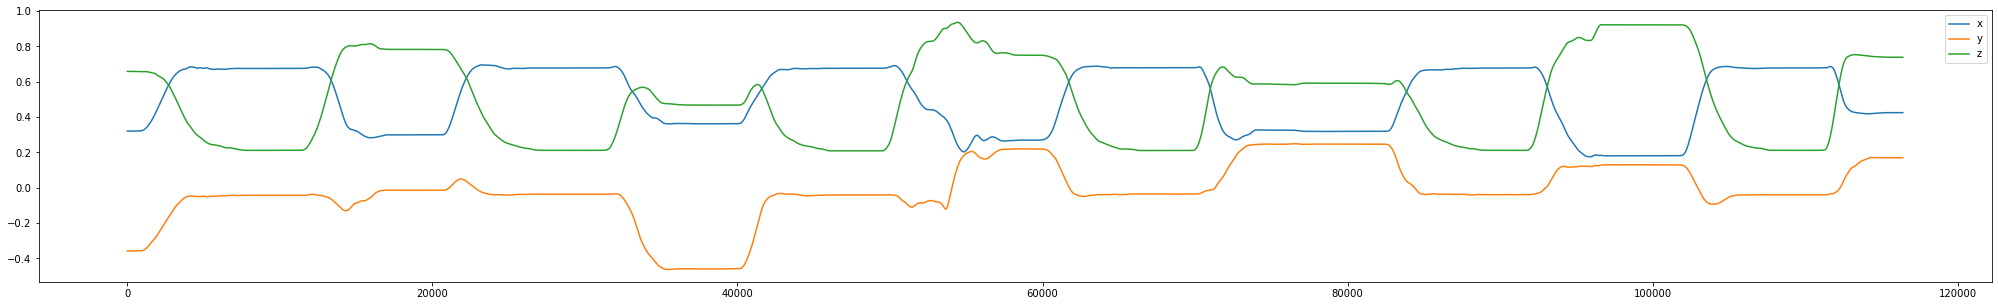

In [3]:
# visualize the data
fig = plt.figure(figsize=(35, 5))
plt.plot(interest_data[:,-7], label = "x")
plt.plot(interest_data[:,-6], label = "y")
plt.plot(interest_data[:,-5], label = "z")
plt.legend()

### Since our demonstrations are always from a high pointion to the low position to do the task, there is a clear pattern in the changes of Z axis. Therefore we also used the value of the Z axis of the goal position to split the whole data to each demonstration.
### We can not use the whole value set of the goal point to judge since in real experiment they won't reach the desired goal value synchronnously.

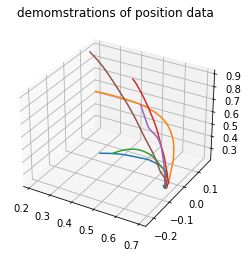

In [4]:
def split(data, goal, goal_index, yita1, yita2):
    """[split the whole process data to several standard demonstrations data according to the given goal]

    Args:
        data ([numpy.array]): [raw data]
        goal ([float]): [one value of the goal point as the split point]
        goal_index ([ind]): [index for the dimension of the raw data corresponding to the dimention that second arg 'goal' refer to]
        yita1 ([float]): [threshold to determain how close to the goal at the end of the demonstration to cut the data]
        yita2 ([float]): [threshhod of the smoonthness of the begining of a demonstration to cut the data]

    Returns:
        [list]: [each element contaions one demonstration data]
    """
    dataset = []
    num = data.shape[0]
    i = j = 0
    while i<num:
        # find the end of this demonstration (close to the goal)
        if ((data[i,goal_index] - goal) < yita1):

            # custommization for our case to speed up
            j = i-4000
            while (data[j,goal_index]<0.4):
                j-=500
            # for general case replace the above by:
            # j = i

            while j>0:
                # go backwards to find the begining (when the changes are smaller than the threshpld)
                if ((data[j-1,goal_index] - data[j,goal_index])< yita2 and (data[j-2,goal_index] - data[j-1,goal_index])< yita2):
                    dataset.append(data[j:i+1,:])
                    break
                j-=1
            # jump out of the current goal point to find the next reaching
            while (data[i,goal_index]<(goal+0.1)):
                i+=100
        i+=1
    return dataset

#values of the goal point
goal_x = 0.6768
goal_y = -0.04434
goal_z = 0.2189

goal_ori1 = 0.01671  #-0.00715
goal_ori2 = 0.9911
goal_ori3 = -0.1321
goal_ori4 = 0.0139
dataset = split(interest_data, goal_z, 2, 0, 0.00005)

# visualize the 6 demonstrations of position data
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(len(dataset)):
    plt.plot(dataset[i][:,0],dataset[i][:,1],dataset[i][:,2])
plt.title("demomstrations of position data")
plt.show()

### Since different demonstrations will not reach the desired goal perfectly for measuring error, we need add the desired goal manually.

In [5]:
# select the data of position
pos_data = []
for i in range(len(dataset)):
    # you can decide how many points you want here
    pos_data.append(dataset[i][-4000:,0:3])
    pos_data[i][-1,0] = goal_x
    pos_data[i][-1,1] = goal_y
    pos_data[i][-1,2] = goal_z

# select the data of orientation
ori_data = []
for i in range(len(dataset)):
    ori_data.append(dataset[i][-4000:,3:])
    ori_data[i][-1,0] =  goal_ori1
    ori_data[i][-1,1] =  goal_ori2
    ori_data[i][-1,2] =  goal_ori3
    ori_data[i][-1,3] =  goal_ori4

### Note that the UQ data can not be used to train directly, they should be transferred to tangent space using Log map

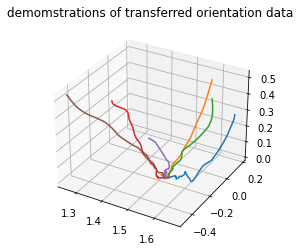

In [6]:
def quat_Log(q):
    """[log map for unit quaternions: convert UQs to vectors]

    Args:
        q ([numpy.array]): [unit quaternion(number*4)]

    Returns:
        [numpy.array]: [vectors on the tangent space(number*3)]
    """
    nEpsilon = np.linalg.norm(q[:,1:], axis= 1).reshape(-1,1)
    qlog = np.arccos(q[:,0]).reshape(-1, 1)*q[:,1:]/nEpsilon
    return qlog

vec_ori = np.zeros((len(ori_data),ori_data[0].shape[0], 3))
for i in range(len(ori_data)):
    vec_ori[i,:,:] = quat_Log(ori_data[i])

# visualize the 6 demonstrations of transferred orientation data
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(vec_ori.shape[0]):
    plt.plot(vec_ori[i,:,0],vec_ori[i,:,1],vec_ori[i,:,2])
plt.title("demomstrations of transferred orientation data")
plt.show()

### Now the data are well-prepared, you can save them into the format you want. Here I saved them to numpy format for further usage.

In [7]:
pos = np.array(pos_data)
print(pos.shape)
# np.save(os.getcwd() + "/../data/Robot_data/training_dataset/real_pos.npy", pos)

print(vec_ori.shape)
# np.save(os.getcwd() + "/../data/Robot_data/training_dataset/real_ori_vec.npy", vec_ori)

(6, 4000, 3)
(6, 4000, 3)


## 2. Training
### First load the above training data and form them to PyTorch dataset (check /../iflow/dataset/robot_uq_dataset.py)
### Train the data using train_uq.py

## 3. Checking the learning results and evaluating
### Here we used the well-trained model in /../robot_model folder for orientation data
### The complete version is written in tobot_test.py

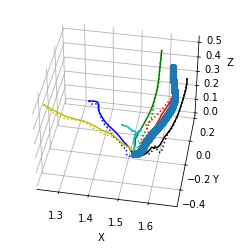

In [8]:
from robot_test import *
##### Must keep the same parameter with the used model parameter file #####
filename = "real_ori_vec"
layers = 11
activation_function = "ReLu"
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

##### load data for model and build the corresponding model for saved model file #####
data = robot_uq_dataset.Robot_UQ(filename = filename, device = device)
dim = data.dim
dynamics = model.TanhStochasticDynamics(dim, device=device, dt=0.003, T_to_stable=3)
flow = create_flow_seq(dim, layers, activation_function)
iflow = model.ContinuousDynamicFlow(dynamics=dynamics, model=flow, dim=dim).to(device)
iflow.load_state_dict(torch.load(os.getcwd() + "/../robot_model/" + filename + "_11_" +"best.pt"))

##### generate new trajectories #####
with torch.no_grad():
    iflow.eval()
    predicted_trajs = []
    ##### using the first point of the demonstrations as the starting point for new trajectories #####
    for trj in data.train_data:
        n_trj = trj.shape[0]
        y0 = trj[0, :]
        y0 = torch.from_numpy(y0[None, :]).float().to(device)
        yn = trj[-1, :]
        yn = torch.from_numpy(yn[None, :]).float().to(device)
        traj_pred = iflow.generate_trj(y0, yn)
        traj_pred = traj_pred.detach().cpu().numpy()
        predicted_trajs.append(traj_pred)

    ##### set new starting points #####
    new_start = np.zeros_like(data.train_data[0][0,:])
    for i in range(3):
        new_start += data.train_data[i][0, :]
    new_start /= 3
    # new_start[0] = -2
    # new_start[1] = -4
    # new_start[2] = 2
    # print(new_start)
    y0 = torch.from_numpy(new_start[None, :]).float().to(device)
    yn = data.train_data[0][-1, :]
    yn = torch.from_numpy(yn[None, :]).float().to(device)
    new_traj_pred = iflow.generate_trj(y0, yn)
    new_traj_pred = new_traj_pred.detach().cpu().numpy()
    # print(new_traj_pred.shape)
    # print("end point:{}".format(new_traj_pred[-1,:]))
    predicted_trajs.append(new_traj_pred)

    ##### unnormalized the generated and demonstration data on the tangent space #####
    unnormed_dem = data.unormalize(data.train_data)
    unnormed_pre = data.unormalize(predicted_trajs)

    ##### check the function for more details #####
    visualize_3d_generated_trj(unnormed_dem, unnormed_pre, device, fig_number=2, view1 =40, view2 = -80) #change the angle of view by args view1 and view2

### Here in this graph, the dot lines are demonstrations and the solid lines are generated predictions corresponding to the demos with the same color. As for the thick blue line, it is the generated prediction from a whole new stating point.